In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from variational import *
from normalizing_flow import *

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
N_TOT = mnist.train.images.shape[0]

# Since we use logit-normal model make sure
# 0. and 1. done't appear in images by adding/subtracting
# epsilon
mnist.train.images[mnist.train.images == 0.] += 0.001
mnist.train.images[mnist.train.images == 1.] -= 0.001

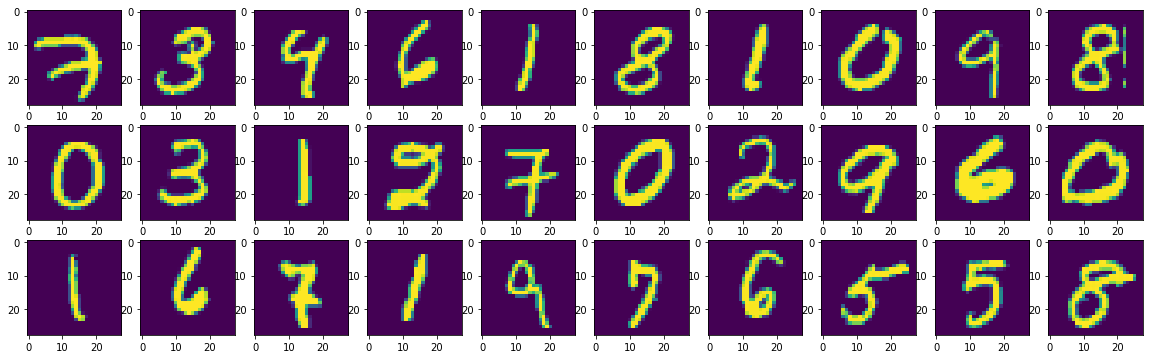

In [3]:
rows, cols = 3, 10
fig, ax = plt.subplots(rows, cols)
for i in range(rows * cols):
    ax[i // 10, i % 10].imshow(mnist.train.images[i, :].reshape([28, 28]))
fig.set_size_inches(2 * cols, 2 * rows)

In [4]:
def shuffled_batch_idx(n_examples, batch_size):
    shuffle_idx = np.random.choice(
        n_examples, n_examples, replace=False)
    rounded = n_examples - n_examples % batch_size
    shuffle_idx = shuffle_idx[:rounded]
    return list(shuffle_idx.reshape([rounded // batch_size, batch_size]))

# Model Parameters and Properties

In [6]:
np.random.seed(85)

NORM_FLOW = False

BATCH_EX = 1
MC_EX = 5
lat_dim = 10
obs_dim = 28 * 28

In [7]:
graph = tf.Graph()

with graph.as_default():
    x = tf.placeholder(dtype=tf.float64, shape=[BATCH_EX, obs_dim], name='input')
    if NORM_FLOW:
        encoder = FlowConditionalVariable(
            dim_x=lat_dim, y=x, flow_layers=1, hidden_units=[512, 256])
        z, log_q = encoder.sample_log_prob(n_samples=MC_EX)
    else:
        # Standard reparametrized normal
        encoder = ReparameterizedDistribution(
            tf.distributions.Normal, MultiLayerPerceptron, input_tensor=x, layers=[256, 128, lat_dim])
        z = encoder.sample(MC_EX)
        log_q = encoder.log_prob(z)

    # The decoder is a reparametrized logit_Normal because images [0., 1.]
    decoder = ReparameterizedDistribution(
            LogitNormal, MultiLayerPerceptron, input_tensor=z, layers=[128, 256, obs_dim])
    x_hat = decoder.sample(1)
    # Prior distribution for codes.
    prior = tf.distributions.Normal(loc=np.zeros(lat_dim), scale=np.ones(lat_dim))

    # ELBO
    elbo = decoder.log_prob(x) + tf.reduce_mean(prior.log_prob(z), axis=-1) - log_q
    elbo = tf.reduce_mean(elbo, axis=0)

    # Choose the optimization algorithm to use
    train_op = tf.train.AdagradOptimizer(learning_rate=.01).minimize(- elbo)
    #train_op = tf.train.AdamOptimizer(learning_rate=.01).minimize(- elbo)

    my_sess = tf.Session()
    my_sess.run(tf.global_variables_initializer())

losses = []
TOT_ITERATIONS = 0
shuffle_idx = []

In [10]:
N_STEPS = 15 * 55000 # 15 full passes

with graph.as_default():
    for i in tqdm(range(N_STEPS)):
        if shuffle_idx == []:
            shuffle_idx = shuffled_batch_idx(N_TOT, BATCH_EX)
        idx = shuffle_idx.pop()
        observation = mnist.train.images[idx, :]
        _, elbo_value = my_sess.run(
            [train_op, elbo], feed_dict={'input:0': observation})
        losses.append(elbo_value)
        TOT_ITERATIONS += 1

100%|██████████| 770000/770000 [1:11:09<00:00, 180.35it/s]


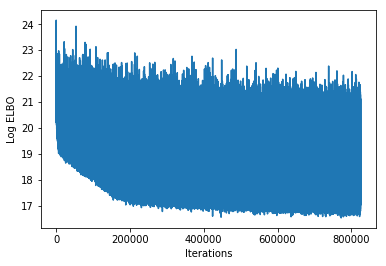

In [11]:
import scipy.signal

def filt(x, log=True, window=101):
    x_ = np.array(x)
    if log:
        x_ = np.log(x_)
    return x_
    return scipy.signal.savgol_filter(x_, window, 3)

plt.plot(filt(-np.array(losses)))
plt.xlabel('Iterations')
plt.ylabel('Log ELBO')

plt.show()

# Latent Probabilistic Codes of Digits

In [12]:
recs = []
codes = []
i = 0
pbar = tqdm(total=N_TOT)
with graph.as_default():
    while i < N_TOT:
        pbar.update(BATCH_EX)
        observation = mnist.train.images[i:i+BATCH_EX, :]
        code_, rec_ = my_sess.run(
            [z, x_hat], feed_dict={'input:0': observation})
        if BATCH_EX == 1:
            recs.append(rec_)
            codes.append(code_)
        else:
            for j in range(rec_.shape[0]):
                recs.append(rec_[j, :, :])
                codes.append(code_[j, :, :])
        i += BATCH_EX

pbar.close()

100%|██████████| 55000/55000 [03:13<00:00, 284.13it/s]


In [13]:
codes1 = np.squeeze(np.array(codes)[:, 0, 0, :])
recs1 = np.squeeze(np.array(recs)[:, 0, 0, 0, :])
codes1.shape, recs1.shape

((55000, 10), (55000, 784))

# Codes and Reconstructions

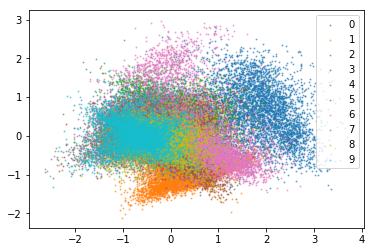

In [14]:
from  sklearn.decomposition import PCA
idx = []

codes = np.array(codes)

pca = PCA(n_components=2)
x_ = pca.fit_transform(np.squeeze(codes[:, 0, :]))

for i in range(10):
    idx.append(mnist.train.labels[:, i] == 1)

for i in range(10):
    plt.scatter(x_[idx[i], 0], x_[idx[i], 1], s=1, alpha=0.5)
#plt.xlim(-40, 40)
#plt.ylim(-20, 20)
plt.legend(range(0, 10))
plt.show()

# Samples from the Generative Model

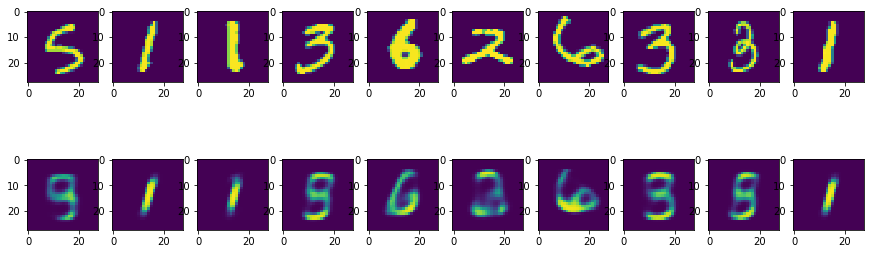

In [18]:
off_set = 10000
fig, ax = plt.subplots(2, 10)
for j in range(10):
    ax[0, j].imshow(np.reshape(mnist.train.images[off_set + j, :], [28, 28]), vmin=0, vmax=1)
    ax[1, j].imshow(np.reshape(recs1[off_set + j], [28, 28]), vmin=0, vmax=1)
fig.set_size_inches(15, 5)
plt.show()

In [27]:
my_sess.close()
